# Hacking Sift
## I. INTRODUCTION
---
The goal of this codelab is to get you into the details of the Scale Invariant Features Transform (SIFT). SIFT is an algorithm in computer vision to detect and to describe local features in images. Its applications include objects recognition, robotic mapping and navigation, image stitching, 3D modeling, video tracking and others.
The lab session has the aim first, to introduce you, both on the theorical and practical aspects of the tool, and then to let you apply the algorithm in a real computer vision applications. After a brief introduction on how SIFT works and on how to apply them, the lab will guide you on building an image stitching pipeline for creating panorama images. The lab has been implemented in python language, using OpenCV and numpy libraries.
The image stitching suggested is composed by a cascade of a features detector module (sift), a features matching module (flann) and an inlier pairs matches estimation for selecting the best matches (ransac). The modules briefly anticipated will be explained thoroughly later on. The approach to image stitching that has been proposed as example can be slower and less accurate compared to some other approaches that do not use features, however the results obtained with this approach are much more robust to noise, lighting gradients and a priori knowledge is not asked about the relative position between images.
Alternatively to SIFT, other features modules, such as surf, orb, brisk, kaze and so on, can be applied in the implementation of the pipeline. Of course, their parameterizations changes completely.

## II. SIFT- SCALE INVARIANT FEATURES TRANSFORM 
---
### A. Overview
A SIFT feature is a salient keypoint that corresponds to an image region, that has associated a descriptor. SIFT computation is commonly divided in two different steps:
* detector;
* descriptor.
At the end of the detection phase, for each features detected, the SIFT algorithm has established:
* keypoint spatial coordinates (x,y); 
* keypoint scale;
* keypoint dominant orientation.
After the detection step, the SIFT descriptor step computes a distinctive fingerprint for each feature. The description obtained is designed to be invariant to scale and rotation. Moreover, the algorithm offers decent robustness to noise, illumination gradients and affine transformations. 

### B. SIFT detector
SIFT detector outcomes are SIFT keypoints. A keypoint is entirely described by 4 values, its x and y keypoint center coordinates, its scale, that is indicated by the radius of the keypoint region, its orientation, that is an angle expressed in radiant that will be explained later on.
![Representation of a detected SIFT keypoint. The four parameters are underlined: spatial coordinates, radius of the region, that determines the scale, and orientation](latex_lab_tutorial_sources/imgs/detected_sift.jpg "Representation of a detected SIFT keypoint. The four parameters are underlined: spatial coordinates, radius of the region, that determines the scale, and orientation")
SIFT detection starts by building a pyramidal scale space of Difference of Gaussians. For explaining the concept of DoG pyramid, the octave will be first introduced. An octave is a n ∗ n box of pixels, with n typically equals to 16, an image is divided in a grid of non-overlapping octaves. A square composed by 4 octaves in an image is mapped in one octave in the layer above, if there are any, and it corresponds to 16 octaves in the layer below, if there are any.
![ Representation of an octave and its relative part in its correspondent downsized. A 16x16 pixels octave in an upper layer is mapped to a 4x4 pixels portion of the correspondent octave downstream.](latex_lab_tutorial_sources/imgs/octave_downsize.jpg "Representation of an octave and its relative part in its correspondent downsized. A 16x16 pixels octave in an upper layer is mapped to a 4x4 pixels portion of the correspondent octave downstream.")

A pyramidal scale space is built by starting from the layer with the highest number of octaves, at the bottom of the pyramid, that may be composed by an octaves grid of the size of original image, or an octaves grid of twice as much the size of the original image (as it happens in Lowe’s SIFT). 
![Representation of a scale space DoG pyramid. There are just 2 octaves. For each octave, there are 4 scales. Each DoG in an octave layer is computed with a decreasing gaussian kernel size. In SIFT Lowe’s paper there are 3 scales for each octave layer.
](latex_lab_tutorial_sources/imgs/dog_pyramid.jpg "Representation of a scale space DoG pyramid. There are just 2 octaves. For each octave, there are 4 scales. Each DoG in an octave layer is computed with a decreasing gaussian kernel size. In SIFT Lowe’s paper there are 3 scales for each octave layer.")

Then, the layers above are iteratively built by successively downsizing the octave grid at the current scale by a factor of 2. It results that a DoG pyramid is composed by $log_2 N$, or $log_2 (N) + 1$, octaves layers, depending on the starting grid size, where N is the minimum between the width and the height of the image. While downsizing the octaves in the pyramid, the gaussian kernel used to compute the DoG is sized up. For instance a downsize of a factor 2 of the octaves, is performed together at an upsizing of a factor of 2 of the gaussian kernel used for the DoG. Nevertheless, one octaves layer may correspond to several DoG of the image, in fact in Lowe’s paper a octaves layer contains 3 different DoG performed with 3 different increasing scales of gaussian kernel (Fig. above). For instance, the first octave layer, supposing that has an octaves grid of the size of the original image, may have associated 3 DoGs, the first obtained with gaussian kernel with sigma 1, the second obtained with gaussian kernel with sigma 1.3, the third obtained with gaussian kernel with sigma 1.6. Then, the sigma of the gaussian kernels in the octave layers above may be 2, 2.3 and 2.6.

In particular, sigma of the gaussian kernels used for computing the DoG pyramid are sampled as:
$$\sigma = \sigma_0*2^{o+s/S},    s = 0,...,S-1,    o=o_{min}, ..., o_{min} + O -1$$

where $\sigma_0=1.6$, $o_{min}$ is the first octave index, O the number of octaves and S the number of scales per octaves.
  
The gaussian smoothed image at a certain scale determined by $\sigma$ is computed by:
$$I_{\sigma} = g_{\sigma} * I$$
where $I$ is the original image and $g_{\sigma}$ is the gaussian kernel for that scale.

The DoG for a certain scale s and certain octave o is:
$$DoG_{\sigma(o,s)} = I_{\sigma(o,s+1)} - I_{\sigma(o,s)}$$
where $o=o_{min},...,o_{min}+O-1$ and $s = 0,...,S-1$
Then, keypoints are identified as local maxima/minima of the DoG images across the scale. Maxima/min-
ima are obtained comparing each pixel with its 8 neighbours, if the pixel is a maximum/minimum within that neighborhood, than it is a SIFT keypoint candidate. For increasing the accuracy of the maxima/minima locations, the DoG scale-space function is interpolated with finer resolution by quadratic Taylor expansion, so that sub-pixel accuracy can be attained.
Local maxima/minima with low contrast are unstable and may be source of error. In order to discard such candidate features, only the candidates with value of second order of the Taylor expansion greater than a certain threshold are kept, while the others are discard. That threshold in the Lowe paper is 0.03, however it should be tuned according to the characteristics of the images that are taken in analysis.
DoG will have strong responses along edges, however candidates features detected over edges are unstable since they have poorly determined spatial location. To increase stability, kepoint candidates with poorly determined locations with high edge response have to be discarded. In order to understand whether a keypoint is on a blob or on an edge, its principal curvature is evaluated. In differential geometry, the two principal curvatures at a given point of a surface are the eigenvalues of the shape operator at that point. They measure how the surface bends by different amounts in different directions at that point. If the keypoint candidate has a principal curvature with the 2 eigenvalues that are strongly different, it is located on an edge, otherwise it is located on a blob, thus is more stable. It follows a score that is related to the ratio of the 2 eigenvalues:

$$R = \frac{(tr D(x,y,\sigma)^2}{det D(x,y,\sigma)} = \frac{(r+1)^2}{r} ,
D = \begin{bmatrix}
\frac{\partial^2{DoG}}{\partial^2{x^2}} & \frac{\partial^2{DoG}}{\partial{x}\partial{y}} \\
\frac{\partial^2{DoG}}{\partial{x}\partial{y}} & \frac{\partial^2{DoG}}{\partial^2{x^2}} 
\end{bmatrix}$$

where
$r = \frac{\alpha}{\beta}$
with $\alpha$ and $\beta$ the 2 eigenvalues.
This score has minimum value 4 when the 2 eigenvalues are equal, and it increases whether their ratio increases. SIFT discards all the candidate keypoints that have an edge score greater than a certain threshold, that in Lowe's paper is 10.

Then, for each keypoint, at the scale that it has been detected, it is precomputed the magnitude and the phase of its gradient over all its extension, that is given by its radius. Thus, a keypoint orientation histogram of 36 channels is built from the gradient phases. Each bin has a resolution of 10°. The histogram is then smoothed. The maximum of the histogram is elected as the main orientation of the keypoint. If there are other orientations that are more than the 80\% respect with the maximum, new keypoints with same spatial coordinates and radius but with the secondary orientations as main orientations are added.

### C. SIFT descriptor
Once that keypoints are detected, SIFT transform is designed to provide a description of such features as well. The feature description has to be highly distinctive, so that it can reduce the probability of features mismatch. However, descriptors have to be robust to changes in illumination, noise and 3D viewpoints. The principle adopted for features descriptor is really similar to the one adopted with HOG, Histogram of Oriented Gradients. For each keypoint detected, a neighborhood of 16x16 pixels is taken into account. This neighborhood is splitted in 4x4 cells, each cell composed by 4x4 pixels. For each cell, a histogram of the oriented gradient relatively to the main orientation detected for that keypoint is computed, in order to attain invariance to rotation. A histogram of oriented gradient is a histogram of the phase of gradients for that cell. The histogram has 8 bins, so each bin has a resolution of 40. Since there are 4x4 cells for each neighborhood relatively to each feature, a 4x4x8 histogram is obtained, for a total of 128 for each features.
![Representation of a SIFT features descriptor. At the left, the keypoint 16x16 pixels neighborhood containing the values of the oriented gradient is divided into 4 cells. At the right, for each one of the four cells, there is a radial representation of the histogram of gradients.](latex_lab_tutorial_sources/imgs/sift_descriptors.jpeg "Representation of a SIFT features descriptor. At the left, the keypoint 16x16 pixels neighborhood containing the values of the oriented gradient is divided into 4 cells. At the right, for each one of the four cells, there is a radial representation of the histogram of gradients.")

### D. Getting things done
The Python/OpenCV code for detecting and describing SIFT features on an image, that you can find in the *get_homographyfunction* in *image_alignment.py* , is:

In [17]:
!pip3 install -U opencv-contrib-python==3.4.11.45

     |████████████████████████████████| 60.5 MB 2.1 MB/s eta 0:00:01
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 3.4.8.29
    Uninstalling opencv-contrib-python-3.4.8.29:
      Successfully uninstalled opencv-contrib-python-3.4.8.29


In [3]:
!pip3 install -U matplotlib

     |████████████████████████████████| 8.5 MB 1.8 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.0
    Uninstalling matplotlib-3.3.0:
      Successfully uninstalled matplotlib-3.3.0


In [1]:
import numpy as np
import cv2
import sys

def getsize(img):
    h, w = img.shape[:2]
    return w, h

class image_alignment_sift(object):

    SIFT = 0
    SURF = 1
    ORB = 2     #should be used just with BF MATCHER (uint8 descriptor)
    BRISK = 3
    
    FLANN = 0
    BFMATCHER = 1

    
    def __init__(self, feat_type, matcher_type=FLANN, params = None):
        self.detector, norm = self.features_detector(feat_type=feat_type, params = params)
        self.matcher = self.features_matcher(matcher_type=matcher_type, norm=norm)
    
    
    def features_detector(self, feat_type = SIFT, params = None):
        
        assert feat_type == self.SIFT or feat_type == self.SURF or \
            feat_type == self.ORB or feat_type == self.BRISK
        
        if feat_type == self.SIFT:
            
            if params is None:
                nfeatures = 0
                nOctaveLayers = 3
                contrastThreshold = 0.04
                edgeThreshold=10
                sigma=1.6
            else:
                nfeatures = params["nfeatures"]
                nOctaveLayers = params["nOctaveLayers"]
                contrastThreshold = params["contrastThreshold"]
                edgeThreshold = params["edgeThreshold"]
                sigma = params["sigma"]

            detector = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures, 
                                                    nOctaveLayers=nOctaveLayers, 
                                                    contrastThreshold=contrastThreshold, 
                                                    edgeThreshold=edgeThreshold, 
                                                    sigma=sigma)
            norm = cv2.NORM_L2
        elif feat_type == self.SURF:
            
            if params is None:
                hessianThreshold = 3000
                nOctaves = 1
                nOctaveLayers = 1
                upright = True
                extended = False
            else:
                hessianThreshold = params["hessianThreshold"]
                nOctaves = params["nOctaves"]
                nOctaveLayers = params["nOctaveLayers"]
                upright = params["upright"]
                extended = params["extended"]
                
            detector = cv2.xfeatures2d.SURF_create(hessianThreshold = hessianThreshold, 
                                nOctaves = nOctaves, 
                                nOctaveLayers = nOctaveLayers, 
                                upright = upright, 
                                extended = extended)
            norm = cv2.NORM_L2
            
        elif feat_type == self.ORB:

            detector = cv2.ORB(nfeatures=8000, scaleFactor=1.1, nlevels=8, edgeThreshold=10, firstLevel=0, WTA_K=2, patchSize=10)
            norm = cv2.NORM_HAMMING
        elif feat_type == self.BRISK:
            detector = cv2.BRISK()
            norm = cv2.NORM_HAMMING
       
        return detector, norm

If you have read carefully the theorical introduction on Scale Invariant Features Transform, these lines of code will look trivial and without mistery. The first line creates a SIFT object detector and descriptor. The second line detects and describes the keypoints. By using the parameters in input at the features detector constructor, it is possible to tune the desired results. If nfeatures is equal to zero, the number of features is determined according to the other parameters, otherwise it is forced to the value specified. The parameter contrastThreshold is the threshold to estabilish whether a feature has low contrast or not. The higher its value, the stronger has to be a feature to be detected. The edge threshold determines whether a keypoint has to be discarded or not depending its principal curvature. Its minimum value is 4, and it allows only perfect blobs. A value of 10 is a good compromise between features stability and detector sensitivity. The sigma parameter determines the sigma of gaussian kernel used to smooth in the scale space. The variable kp1 is a list of the detected keypoints, that includes their spatial coordinates, their radius and their orientation. The variable desc1 indicates the descriptors relative to those points.
By checking OpenCV documentation and tutorials online, write the code necessary to visualize de- tected Sift. The code has to be inserted in the get_homography method of the image_alignment class in image_alignment.py module.
What do you expect when the contrast threshold is increased or decreased? What do you expect when the edge threshold is increased or decreased? Try to answer by the theorical understading that you have on SIFT, and later on, by observing the detected features, try experimentally different values and observe the results that you obtain. Was your guess confirmed?

## III. FLANN - FAST LINEAR APPROXIMATED NEAREST NEIGHBOURS 
---
### A. Features pairing
Object instances matching is a typical application where tools like SIFT are applied. It consists of matching the same object presents in two different images. The object instances may be rotated, they may have perspective 3D view point distortions or they may be affected by noise. Instances matching with SIFT requires that features of the instances of the same object are matched. Image stitching for building a panorama pictures requires this matching step as well. In fact, features belonging to objects that are shared between the different perspectives are used to perform the alignment to build the panorama. Those features are paired by means of their descriptors. The challenge to pair high dimensional descriptors, as sift descriptors are, it is called to find the nearest neighbours. Exact nearest neighbours do not scale well with the increase of dimensionality of the descriptors and numbers of features. So, an approximate approach is chosen for trading off accuracy while matching faster.
FLANN library selects the best performing approximate nearest neighbours algorithm for the dataset. The algorithm selection is performed by cross-validation on a small chunk of the dataset where to perform nearest neighbors search. FLANN features matching is not robust by itself. Several pairs are wrong, since matching is approximate and features descriptors may fail in being distinctive enough. Wrong pairs may become an issue that may compromise image stitching process, if not addressed. A method for dealing with erroneous matching will be explained later on.

### B. Getting things done
The Python/OpenCV code to implement flann, in the method *filter_matches* of *image_alignment* class, follows:

In [2]:
"""
FLANN INDEX KDTREE = 1 # opencv bug : flann enums are missing
norm = cv2 .NORM L2 # with different norms parameters may change
flann params = dict ( algorithm = FLANN INDEX KDTREE, trees = 5)
matcher = cv2 . FlannBasedMatcher ( flann params , {})
raw matches = matcher.knnMatch(desc1 , trainDescriptors = desc2 , k = 2)
p1, p2, kp pairs = filter matches(kp1, kp2, raw matches)
"""

class image_alignment_matcher(image_alignment_sift):

    def features_matcher(self, matcher_type = image_alignment_sift.FLANN , norm = cv2.NORM_L2 ):
        
        FLANN_INDEX_KDTREE = 1  # opencv bug: flann enums are missing
        FLANN_INDEX_LSH    = 6
        
        if matcher_type==self.FLANN:
            if norm == cv2.NORM_L2:
                flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            else:
                flann_params= dict(algorithm = FLANN_INDEX_LSH,
                               table_number = 6, # 12
                               key_size = 12,     # 20
                               multi_probe_level = 1) #2
            matcher = cv2.FlannBasedMatcher(flann_params, {})  # bug : need to pass empty dict (#1329)
        else:
            matcher = cv2.BFMatcher(norm)
        
        return matcher

The first 4 lines initialize the FLANN matcher. The variables kp1 and desc1 are the features detected in the first image and their relative descriptors. The variables kp2 and desc2 are the features in the second image and their relative descriptors. The knnMatch method of the matcher object find the best pair of neighbours and the second best matching pair, since k is equal to 2. The method ”filter matches” is supposed to discard weak pairs. In fact, if the best matching pair distance is not way smaller than the second best matching pair distance, probably the matched features are not so distinctive, and so that matching should not be considered reliable and it should be discarded. Considering that ”raw matches” is a python list, and its elements are tuple containing the best match and the second best match, the code for filtering the matches may contain something like below.

<div class="alert alert-success">

<b>EXERCISE 1</b>:
Implement yourself the missing part of the method. What do you expect to obtain while varying the variable ratio? When you will be done in implementing your alignment pipeline, try different values of ratio and look at the differences.Think about to use the explore matching function provided to you in the annex at the end of this lab track for visualizing differences in the obtained results.
</div>

In [3]:
class image_alignment_filtering(image_alignment_matcher):

    def filter_matches(self, kp1, kp2, matches, ratio = 0.75):
        
        mkp1, mkp2 = [], []
        
        for m in matches:
            
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                """
                matches is a list. m, an item of matches, a list as well,
                containing as first item the best match, encoded as a DMatch, 
                and the second item, the second best match, encoded as a DMatch.
                DMatch is an object that has as attributes, queryIdx and trainIdx
                that indicates the indeces of the matched points from kp1 and kp2.
                Creates two lists, mpk1 and mpk2 that contains sorted kp1 points 
                and kp2 points, such that are mantained the same indeces of 
                the matched points.
                """                

                #TODO

                #Remove the next line when the exercise on sorting matched keypoints is done.
                ### BEGIN SOLUTION
                m = m[0]
                mkp1.append( kp1[m.queryIdx] )
                mkp2.append( kp2[m.trainIdx] )
                ### END SOLUTION
                
        p1 = np.float32([kp.pt for kp in mkp1])
        p2 = np.float32([kp.pt for kp in mkp2])
        kp_pairs = zip(mkp1, mkp2)
        
        return p1, p2, kp_pairs

![Pair matching of two view of New York skyline.](latex_lab_tutorial_sources/imgs/correspondences_rockfeller_landscape.png "Pair matching of two view of New York skyline.")

## IV. RANSAC - RANDOM SAMPLE CONSENSUS ALGORITHM 
---
### A. Homography design with RANSAC
Some features pairs are correct, while some others are completely wrong. If the image homograhy designed to perform overlapping is calculated by minimizing the linear projection error that takes into account also the incorrect pairs, the final result will be affected by a displacement that would make the alignment unpleasant for the observers. In order to have acceptable panorama pictures, such an error cannot be accepted, since even really small displacement results are really tedious to sight. So, instead of linear projection, RANSAC is applied. RANSAC is an algorithm that selects a subset of inliers pairs matching, while discarding outliers matching. Inliers are pairs that are ”coherent” with the homography for overlapping, while outliers do not fit into it. Consider a dataset of N features pairs, RANSAC select a smaller subset of M features pairs and calculate the homography model according to them. Just 4 matches are necessary to compute a model of the homography. After calculated the homography, it establishes the number of features pairs that are closer than a certain tolerance, the inliers. If the number of inliers is bigger than a number K, it found a suitable solution, otherwise it will try a new solution selecting a new subset of M samples and repeating the previous steps. In this way, outliers are discarded and only best matches are kept to perform the overlapping. This method relies on the assumtion that is highly likely that there are at least K good pairs of matches, the so called inliers.


### B. Getting things done
It follows the code for ransac and homography computation in python and OpenCV.


In [4]:
class image_alignment(image_alignment_filtering):
    def __init__(self, feat_type, matcher_type=image_alignment_sift.FLANN, params = None):
        image_alignment_sift.__init__(self, feat_type, matcher_type=image_alignment_sift.FLANN, params = None)

    def get_homography(self, img1, img2, mask1=None, mask2=None):
                        
        kp1, desc1 = self.detector.detectAndCompute(img1, None)
        kp2, desc2 = self.detector.detectAndCompute(img2, None)
        
        """Visualize here detected keypoints

        TODO	

        """
        #remove this after having done the exercise on visualizing detected points!!!
        ### BEGIN SOLUTION
        
        ### END SOLUTION

        raw_matches = self.matcher.knnMatch(desc1, trainDescriptors = desc2, k = 2)
        p1, p2, kp_pairs = self.filter_matches(kp1, kp2, raw_matches)
        if len(p1) >= 4:
            H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)

            return H, status
        else:
            return None, None
    
    def align(self, img1, img2, mask1=None, mask2=None):
                
        H, status = self.get_homography(img2, img1, mask2, mask1)
            
        if H is None:
            return None, None, None # img1, img2, H
        
        img2_aligned = cv2.warpPerspective(img2.Image, H, getsize(img2.Image))
        
        assert img2_aligned is not None
        
        return img1, img2_aligned, H

The first 2 parameters are a list of matched points. The third parameter selects the method to be used to design the homography. The fourth parameter ```ransacReprojThreshold``` represents the ```K``` introduced previously, it indicates the number of inliers that have to be found. It makes sense to set this parameter somewhere in between 4 and 10. Have fun in experimenting changes in the parameters.

## V. IMAGES BLENDING AND OVERLAPPING
---
### A. Avoiding abrupt changes in lighting conditions
Once that the homography matrix is computed, the homography can be applied to the source image, so that it will overlap to the target image. For doing so, it is possible simply to use the cv2.warpPerspective function in OpenCV library. However, this is not enough in order to obtain good panorama images. In fact there may be strong differences of lights due to the fact that exposure times of the shutters and white balance control of the cameras changes when capturing the same scene by different perspectives. So it is necessary to perform images blending, in order to make smoother the discontinuities between the two overlapped pictures.

### B. Getting things done
In this paragraph, it is proposed a solution to the blending and overlapping challenge. However, this code does handle only overlapping of horizontal panorama. Feel encouraged to experiment blending and overlapping functions that handle vertical alignment and so on. It follows the proposed code of the functions used to perform the overlapping:

In [5]:
import numpy as np
import cv2

#given the height and the width of the panorama, and the barrier, that indicates #where there is the discontinuity between the images , this function produce
#a smoothed transient in the overlapping .
#smoothing window is a parameter that determines the width of the transient #left biased is a flag that determines whether it is masked the left image,
#or the right one
def blending_mask(height, width, barrier, smoothing_window, left_biased=True):
    assert barrier < width
    mask = np.zeros((height, width))
    offset = int(smoothing_window/2) 
    if left_biased:
        mask[:,barrier-offset:barrier+offset+1]=np.tile(np.linspace(1,0,2*offset+1).T, (height, 1))
        mask[:,:barrier-offset] = 1 
    else :
        mask[:,barrier-offset:barrier+offset+1]=np.tile(np.linspace(0,1,2*offset+1).T, (height, 1)) 
        mask[: , barrier+offset :] = 1
    return cv2.merge([mask, mask, mask])

<div class="alert alert-success">

<b>QUESTION 1</b>:
Are you familiar with broadcasting addressing in numpy array? Check it out on numpy documentation. What is the the method ```linspace``` of numpy library supposed to do? And the method ```tile```? Check them out as well.
</div>

In [6]:
#this function apply the homography to img2 and it performs the blending while doing so
def images_blending (img1 , img2 , width_panorama , height_panorama , H, smoothing_window = 400) :
    barrier = img1.shape[1] -int(smoothing_window/2)
    panorama1 = np.zeros((height_panorama, width_panorama, 3))
    mask1 = blending_mask ( height_panorama , width_panorama , barrier , smoothing_window = smoothing_window ,
    left_biased = True)
    panorama1[0:img1.shape[0] ,0:img1.shape[1] ,:] = img1 
    panorama1 *= mask1
    mask2 = blending_mask ( height_panorama , width_panorama , barrier , smoothing_window = smoothing_window , left_biased = False)
    panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama)) * mask2 
    return panorama1 + panorama2

Those methods can be found in the ```blending.py``` module. 

<div class="alert alert-success">

<b>QUESTION 2</b>:
What is this function supposed to do in detail?
</div>

In [7]:
#apply the homography for overlapping images, meanwhile performing blending between 2   

import os
from matplotlib import pyplot as plt
%matplotlib inline

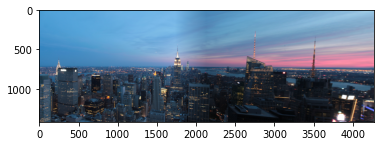

In [8]:
fn_base = "source/data/"
#edit here for trying with different images
fn_img1 = "rockfeller_1.JPG"
fn_img2 = "rockfeller_2.JPG"

#reading images
img1 = cv2.cvtColor(cv2.imread(os.path.join(fn_base, fn_img1)),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(os.path.join(fn_base, fn_img2)),cv2.COLOR_BGR2RGB)

height_img1 = img1.shape[0]
width_img1 = img1.shape[1]
nch_img1 = img1.shape[2]
#watch out: coordinates in opencv are inverted compared to numpy!
img1 = cv2.resize(img1, (width_img1//2, height_img1//2))

height_img2 = img2.shape[0]
width_img2 = img2.shape[1]
nch_img2 = img2.shape[2]
img2 = cv2.resize(img2, (width_img2//2, height_img2//2))

assert nch_img1 == nch_img2

height_panorama = height_img1 // 2
width_panorama = width_img1  

#sift parameters
sift_params = dict()
#number of features, if 0, the number will be determined according to the other 
#parameters
sift_params["nfeatures"] = 0
sift_params["nOctaveLayers"] = 3
#the higher the threshold, the strongest features are kept, while the other
#are discarded
sift_params["contrastThreshold"] = 0.04
sift_params["edgeThreshold"] = 10
#sigma of the blurring gaussian kernel used for smoothing when building the
#pyramid
sift_params["sigma"] = 1.6

#creating the instance of the image aligner
img_align = image_alignment(feat_type = image_alignment_sift.SIFT, params = sift_params)
#designing the homography matrix by detecting matches between features in the
#two images
#sift features computation -> flann (approximate nearest neighbours) -> ransac for outliers removal

H, status = img_align.get_homography(img2, img1)
#apply the homography for overlapping images, meanwhile performing blending between
#them
panorama_image = images_blending(img1, img2, width_panorama, height_panorama, H)

#saving the panorama image
#cv2.imwrite(os.path.join(fn_base,"panorama.jpg"), panorama_image)
plt.imshow(panorama_image.astype(np.uint8))

## VII. DO IT YOURSELF!
---
Go through the code again and change the parameters given to the constructor of the images_alignment class, so that you can implement the image stitching pipeline with SURF and ORB features. 

<div class="alert alert-success">

<b>QUESTION 3</b>:
Compare the results obtained in terms of speed and accuracy.
Which one is the most accurated method? Which one the least? Which one is the faster method? Which one is the slower?
I hope you have enjoyed it!
</div>

## VIII. ANNEX
---

<div class="alert alert-success">

<b>Visualize detected features and paired matches</b>:

Look at the snippet of code below. It is really important to visualize the outcome for debugging purposes. It may help your understanding!
</div>

In [ ]:
def explore_match (img1 , img2 , kp_pairs , status = None , H = None):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    vis = np.zeros((max(h1, h2), w1+w2), np.uint8) 
    vis[:h1, :w1] = img1
    vis[:h2, w1:w1+w2] = img2
    vis = cv2.cvtColor ( vis , cv2.COLOR_GRAY2BGR)
    
    if H is not None:
        corners = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
        corners = np.int32( cv2.perspectiveTransform(corners.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0) ) 
        cv2.polylines(vis , [corners], True, (255, 255, 255))
        
    if status is None:
        status = np.ones(len(kp_pairs), np.bool )
    p1 = np.int32([kpp[0].pt for kpp in kp_pairs])
    p2 = np.int32([kpp[1].pt for kpp in kp_pairs]) + (w1, 0) #w1 is the width of the first image
    
    green = (0, 255, 0)
    red = (0, 0, 255)
    white = (255 , 255 , 255)
    kp_color = (51, 103, 236)
    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            col = green
            cv2.circle(vis, (x1, y1), 2, col, -1) 
            cv2.circle(vis, (x2, y2), 2, col, -1)
        else:
            col = red
            r=2
            thickness = 3
            cv2.line(vis, (x1-r, y1-r), (x1+r, y1+r), col, thickness)
            cv2.line(vis, (x1-r, y1+r), (x1+r, y1-r), col, thickness)
            cv2.line(vis, (x2-r, y2-r), (x2+r, y2+r), col, thickness)
            cv2.line(vis, (x2-r, y2+r), (x2+r, y2-r), col, thickness)
    
    vis0 = vis.copy()
    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            cv2.line(vis, (x1, y1), (x2, y2), green)
    return vis